In [ ]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version

# install detectron2:
!pip3 install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 26kB/s 
     |████████████████████████████████| 4.1MB 16.3MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=beaa8706f184f88c07ed32665ec0f32ca1a177c8507aac83c6a4ce975039c26a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [ ]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import random
import pandas as pd
from detectron2.data import DatasetCatalog, MetadataCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# write a function that loads the dataset into detectron2's standard format
def get_microcontroller_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['result','testname','date','text','values']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

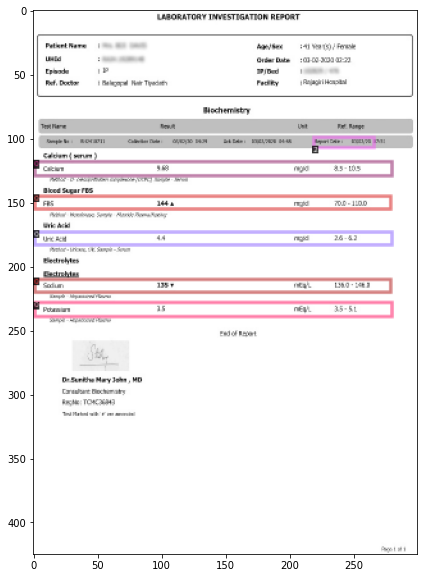

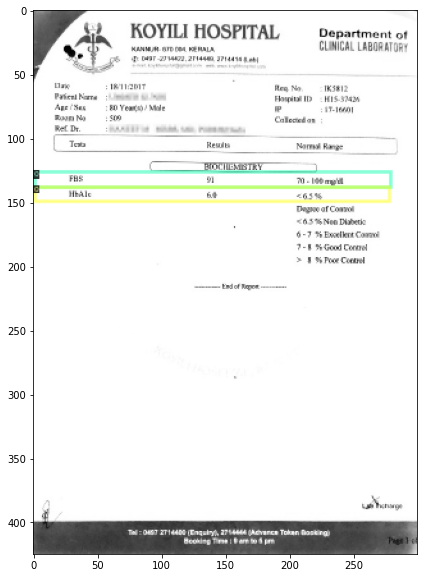

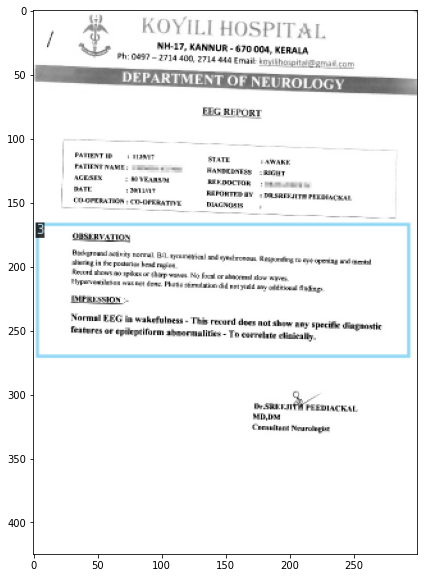

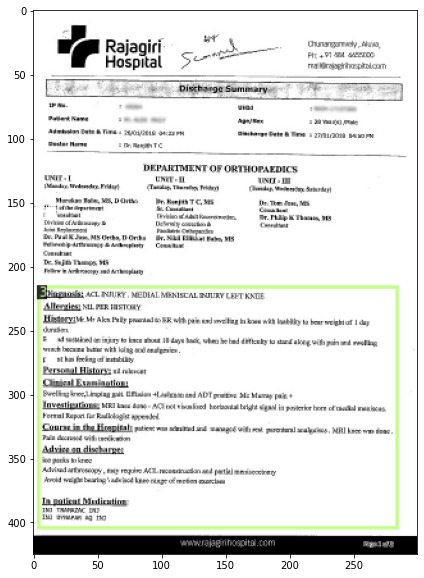

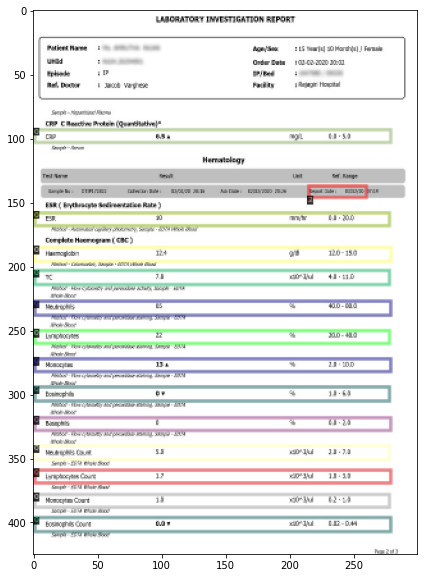

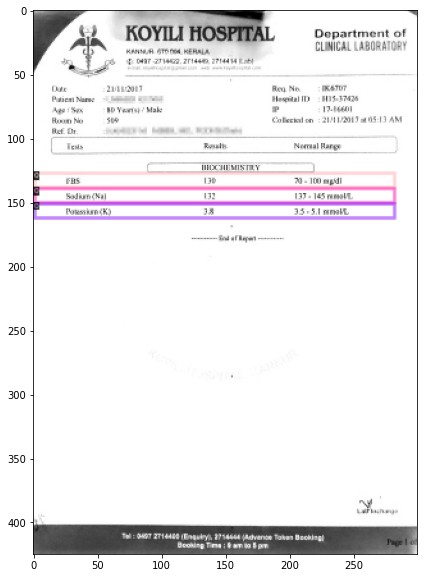

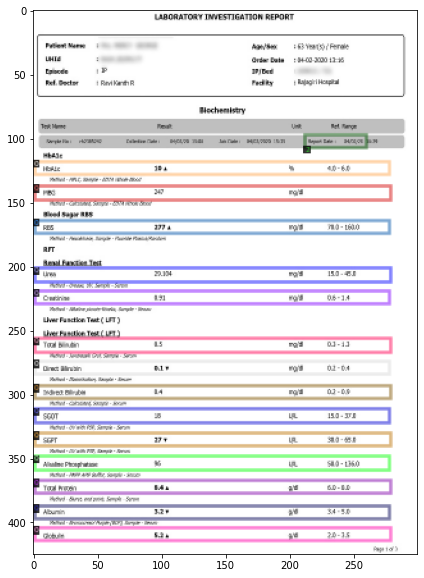

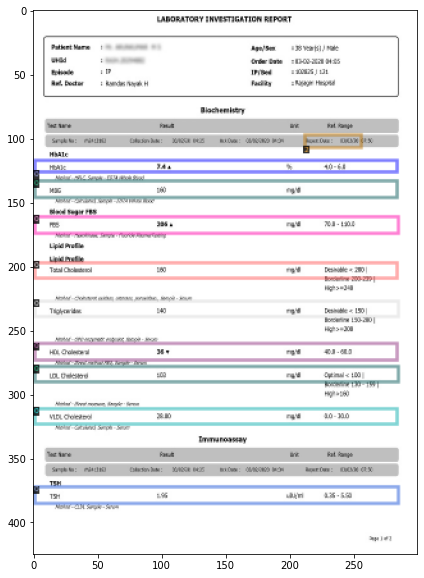

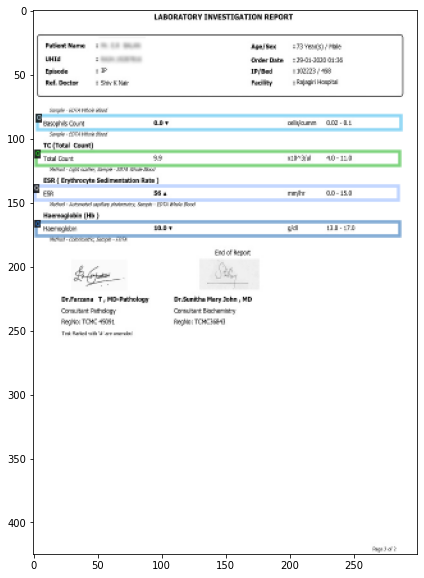

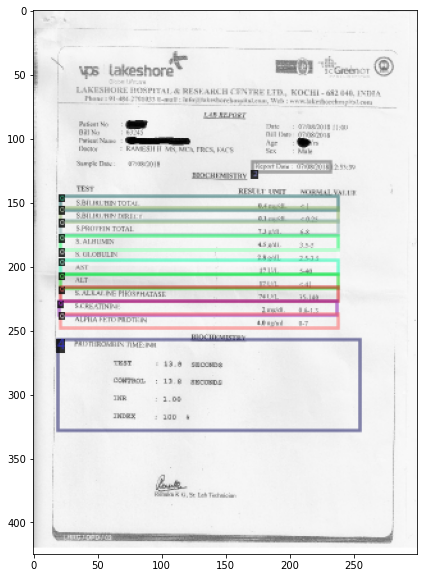

In [ ]:
dataset_dicts = get_microcontroller_dicts('report_detection/train_labels.csv', 'report_detection/train/')
reports_metadata = MetadataCatalog.get('report_detection/train')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=reports_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
classes = ['result','testname','date','text','values']
for d in ["train","test"]:
  DatasetCatalog.register('report/' + d, lambda d=d: get_microcontroller_dicts('report_detection/' + d + '_labels.csv', 'report_detection/' + d+'/'))
  MetadataCatalog.get('report/' + d).set(thing_classes=classes)
reports_metadata = MetadataCatalog.get('report/train')

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('report/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[06/26 15:57:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:10, 22.2MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model!


[06/26 15:58:12 d2.engine.train_loop]: Starting training from iteration 0
[06/26 15:59:26 d2.utils.events]:  eta: 1:01:31  iter: 19  total_loss: 1.824  loss_cls: 1.087  loss_box_reg: 0.174  loss_rpn_cls: 0.109  loss_rpn_loc: 0.532  time: 3.7879  data_time: 0.0443  lr: 0.000400  max_mem: 5983M
[06/26 16:00:42 d2.utils.events]:  eta: 1:00:24  iter: 39  total_loss: 0.786  loss_cls: 0.212  loss_box_reg: 0.166  loss_rpn_cls: 0.072  loss_rpn_loc: 0.308  time: 3.7959  data_time: 0.0163  lr: 0.000799  max_mem: 5983M
[06/26 16:01:55 d2.utils.events]:  eta: 0:58:36  iter: 59  total_loss: 0.589  loss_cls: 0.158  loss_box_reg: 0.141  loss_rpn_cls: 0.047  loss_rpn_loc: 0.203  time: 3.7421  data_time: 0.0153  lr: 0.001199  max_mem: 5983M
[06/26 16:03:11 d2.utils.events]:  eta: 0:57:51  iter: 79  total_loss: 0.610  loss_cls: 0.134  loss_box_reg: 0.182  loss_rpn_cls: 0.036  loss_rpn_loc: 0.255  time: 3.7478  data_time: 0.0165  lr: 0.001598  max_mem: 5983M
[06/26 16:04:23 d2.utils.events]:  eta: 0:56:1

In [ ]:
# !/opt/bin/nvidia-smi
!ps -aux|grep python
# torch.cuda.empty_cache()

In [ ]:
!kill -9 1605

{'instances': Instances(num_instances=2, image_height=850, image_width=600, fields=[pred_boxes: Boxes(tensor([[ 13.5641, 258.9529, 551.4038, 278.1751],
        [ 18.7603, 282.7006, 554.0931, 302.8347]], device='cuda:0')), scores: tensor([0.9227, 0.8804], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}


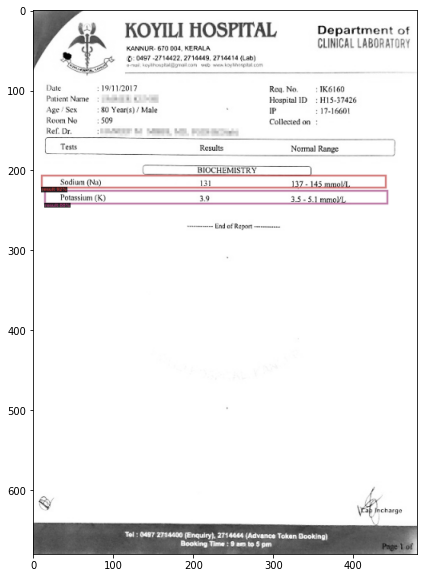

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ('report/test', )
predictor = DefaultPredictor(cfg)

# df_test = pd.read_csv('report_detection/test_labels.csv')

# dataset_dicts = DatasetCatalog.get('report/test')
# for d in random.sample(dataset_dicts, 5):    
im = cv2.imread("report_detection/test/e25.jpg")
outputs = predictor(im)
print(outputs)
v = Visualizer(im[:, :, ::-1], metadata=reports_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

In [ ]:
python tools/infer_simple.py \
--cfg configs/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml \
--output-dir demo/output \
--image-ext jpg \
--wts \
https://s3-us-west-2.amazonaws.com/detectron/35861858/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml.02_32_51.SgT4y1cO/output/train/coco_2014_train:coco_2014_valminusminival/generalized_rcnn/model_final.pkl \
demo

SyntaxError: ignored

In [ ]:
!git clone --recursive https://github.com/caffe2/caffe2.git && cd caffe2
!make && cd build && sudo make install
!python -c 'from caffe2.python import core' 2>/dev/null && echo "Success" || echo "Failure"

Cloning into 'caffe2'...
remote: Enumerating objects: 230451, done.
remote: Total 230451 (delta 0), reused 0 (delta 0), pack-reused 230451
Receiving objects: 100% (230451/230451), 392.86 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (211843/211843), done.
make: *** No targets specified and no makefile found.  Stop.
Success
